In [1]:
# importing standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import math
import seaborn as sns

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet


from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

from itertools import combinations

import statsmodels.api as sm
import scipy.stats as stats

In [2]:
# starting from the clean data set saved in the cleaning notebook
df = pd.read_csv('../data/data_cleaned.csv')

In [18]:
df

,State FIPS Code,County FIPS Code,5-digit FIPS Code,State Abbreviation,Name,Release Year,Premature death raw value,Poor mental health days raw value,Low birthweight raw value,Adult smoking raw value,...,% 65 and older raw value,% Non-Hispanic African American raw value,% American Indian and Alaskan Native raw value,% Asian raw value,% Native Hawaiian/Other Pacific Islander raw value,% Hispanic raw value,% Non-Hispanic white raw value,% not proficient in English raw value,% Females raw value,% Rural raw value
0,1,1,1001,AL,Autauga County,2019,8824.057123,4.306739,0.084757,0.191247,...,0.151196,0.192545,0.004756,0.012792,0.001045,0.028575,0.744739,0.008285,0.513422,0.420022
1,1,3,1003,AL,Baldwin County,2019,7224.632160,4.249649,0.083387,0.167955,...,0.199470,0.089532,0.007760,0.011565,0.000687,0.045502,0.830474,0.004545,0.514528,0.422791
2,1,5,1005,AL,Barbour County,2019,9586.165037,4.634994,0.109526,0.215409,...,0.188247,0.479422,0.006529,0.004630,0.001860,0.042066,0.459557,0.011993,0.472299,0.677896
3,1,7,1007,AL,Bibb County,2019,11783.543675,4.315710,0.111050,0.199164,...,0.160226,0.214576,0.004279,0.002206,0.001147,0.026381,0.742986,0.003943,0.464531,0.683526
4,1,9,1009,AL,Blount County,2019,10908.101822,4.701599,0.079268,0.196522,...,0.178426,0.014600,0.006326,0.003017,0.001172,0.095651,0.869443,0.018700,0.506886,0.899515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,56,37,56037,WY,Sweetwater County,2019,7497.439952,3.543546,0.094205,0.175669,...,0.113750,0.010911,0.015344,0.008338,0.001424,0.162494,0.793587,0.015828,0.484541,0.109163
3138,56,39,56039,WY,Teton County,2019,3786.128226,3.072253,0.074739,0.141373,...,0.143950,0.005330,0.009069,0.012293,0.001332,0.149839,0.817021,0.040420,0.480980,0.464309
3139,56,41,56041,WY,Uinta County,2019,7790.302043,3.699922,0.096475,0.181806,...,0.131886,0.006831,0.013955,0.004928,0.001757,0.091632,0.874750,0.009114,0.495731,0.430959
3140,56,43,56043,WY,Washakie County,2019,5504.650970,3.479694,0.073209,0.156076,...,0.208085,0.004712,0.017237,0.007564,0.001116,0.142485,0.824281,0.003462,0.494668,0.359545


In [3]:
df.columns

Index(['State FIPS Code', 'County FIPS Code', '5-digit FIPS Code',
       'State Abbreviation', 'Name', 'Release Year',
       'Premature death raw value', 'Poor or fair health raw value',
       'Poor physical health days raw value',
       'Poor mental health days raw value', 'Low birthweight raw value',
       'Adult smoking raw value', 'Adult obesity raw value',
       'Food environment index raw value', 'Physical inactivity raw value',
       'Access to exercise opportunities raw value',
       'Excessive drinking raw value',
       'Alcohol-impaired driving deaths raw value',
       'Sexually transmitted infections raw value', 'Teen births raw value',
       'Uninsured raw value', 'Primary care physicians raw value',
       'Dentists raw value', 'Mental health providers raw value',
       'Preventable hospital stays raw value',
       'Mammography screening raw value', 'Flu vaccinations raw value',
       'High school graduation raw value', 'Some college raw value',
       'Unemp

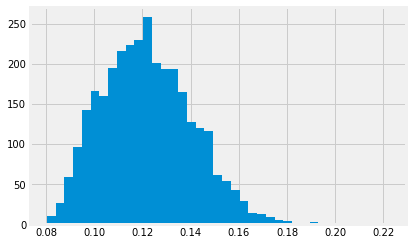

In [4]:
plt.hist(df['Frequent mental distress raw value'], bins = 'auto')
plt.show()

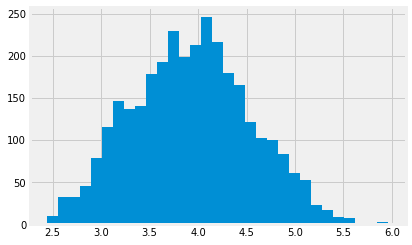

In [5]:
plt.hist(df['Poor mental health days raw value'], bins = 'auto')
plt.show()

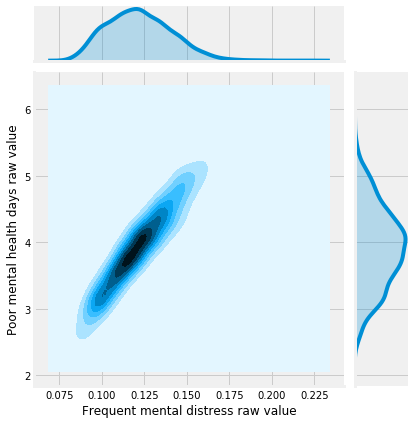

In [6]:
sns.jointplot("Frequent mental distress raw value", "Poor mental health days raw value", data=df, kind='kde')
plt.show()

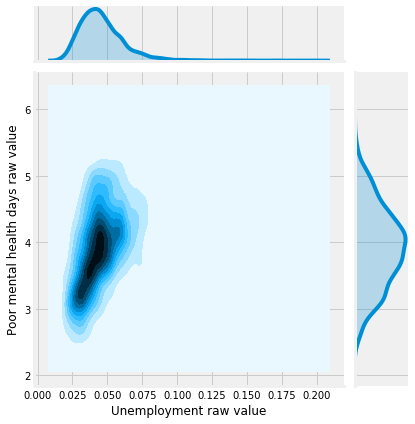

In [7]:
sns.jointplot("Unemployment raw value", "Poor mental health days raw value", data=df, kind='kde')
plt.show()

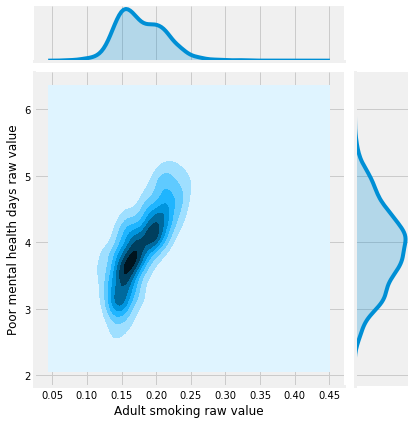

In [8]:
sns.jointplot("Adult smoking raw value", "Poor mental health days raw value", data=df, kind='kde')
plt.show()

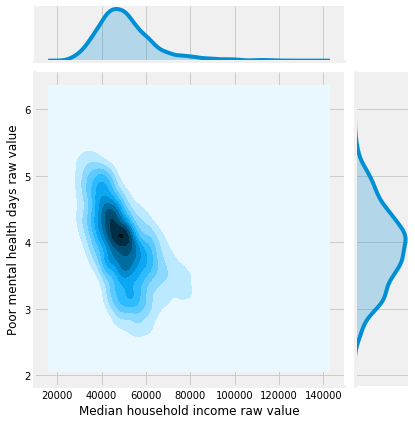

In [9]:
sns.jointplot("Median household income raw value", "Poor mental health days raw value", data=df, kind='kde')
plt.show()

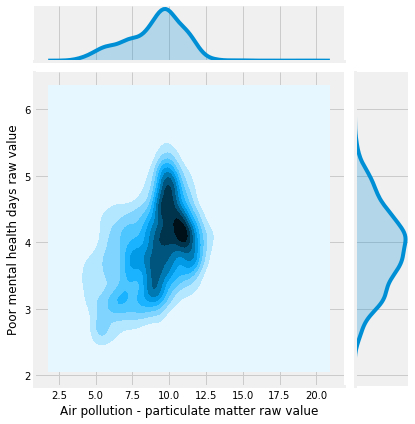

In [10]:
sns.jointplot("Air pollution - particulate matter raw value", "Poor mental health days raw value", data=df, kind='kde')
plt.show()

In [11]:
# starting modeling with a linear regression, checking correlation 
# with our dependent value which will be "Poor mental health days raw value"

df_for_corr = df.iloc[:,6:]
df_for_corr = df_for_corr.corr()

In [12]:
# checking positive variables first
df_for_corr['Poor mental health days raw value'].sort_values(ascending = False).head(10)

Poor mental health days raw value             1.000000
Frequent mental distress raw value            0.953254
Poor physical health days raw value           0.919823
Frequent physical distress raw value          0.878407
Poor or fair health raw value                 0.743129
Adult smoking raw value                       0.739957
Insufficient sleep raw value                  0.691513
Diabetes prevalence raw value                 0.655154
Premature age-adjusted mortality raw value    0.647103
Children in poverty raw value                 0.638065
Name: Poor mental health days raw value, dtype: float64

In [13]:
columns_to_exclude_trivial = []
columns_to_exclude_trivial.extend(
    ['Frequent mental distress raw value', 'Poor physical health days raw value', 
     'Frequent physical distress raw value', 'Poor or fair health raw value'])

In [14]:
# checking negative
df_for_corr['Poor mental health days raw value'].sort_values(ascending = True).head(10)

Life expectancy raw value                    -0.633379
Excessive drinking raw value                 -0.620358
Median household income raw value            -0.559596
Some college raw value                       -0.546793
Food environment index raw value             -0.403171
Mammography screening raw value              -0.342726
Social associations raw value                -0.330864
Access to exercise opportunities raw value   -0.215343
% Asian raw value                            -0.197639
Uninsured children raw value                 -0.183329
Name: Poor mental health days raw value, dtype: float64

In [15]:
columns_to_exclude_trivial.extend(['Life expectancy raw value'])

In [16]:
df.drop(labels = columns_to_exclude_trivial, axis = 1, inplace = True)
df.shape

(3142, 63)

In [20]:
# check for multicolinearity
X = df.drop(['State FIPS Code', 'County FIPS Code', '5-digit FIPS Code', 'State Abbreviation', 'Name', 'Release Year',
    'Poor mental health days raw value'], axis = 1)

In [21]:
# the code will run for a while, and print out the name of the column it just dropped

vif_threshold = 10

columns_to_drop_vif = []
highest_vif_too_high = True

while highest_vif_too_high:
    vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif_list = list(zip(X.columns, vif))
    vif_list = sorted(vif_list, key= lambda x: x[1], reverse = True)
    if vif_list[0][1] > vif_threshold:
        current_column_to_drop = vif_list[0][0]
        print(current_column_to_drop)
        columns_to_drop_vif.append(current_column_to_drop)
        X.drop(current_column_to_drop, axis = 1, inplace = True)
    else:
        highest_vif_too_high = False

Uninsured raw value
% Non-Hispanic white raw value
% Females raw value
Food environment index raw value
Premature age-adjusted mortality raw value
Insufficient sleep raw value
Homeownership raw value
Driving alone to work raw value
High school graduation raw value
Adult obesity raw value
Adult smoking raw value
Diabetes prevalence raw value
% below 18 years of age raw value
Income inequality raw value
Median household income raw value
Physical inactivity raw value
Some college raw value
Food insecurity raw value
Mammography screening raw value
Severe housing problems raw value
Low birthweight raw value
Premature death raw value
Excessive drinking raw value
% 65 and older raw value
Children in poverty raw value
Air pollution - particulate matter raw value
Children in single-parent households raw value
Uninsured adults raw value
Children eligible for free or reduced price lunch raw value
Injury deaths raw value
Flu vaccinations raw value
Severe housing cost burden raw value
Access to exe

In [23]:
# There is high levels of multicollinearity across the values, but we do not want to lose all this information 
# so we are going to risk having high multicollinearity for now and see if it improves model performance

# cross-referencing the variables with multicollinearity against 
# the list of variables with hig correlation with the target varible
correl_test_df = pd.DataFrame()
correl_test_df['column_name'] = columns_to_drop_vif

correl_list = []

for column in columns_to_drop_vif:
    current_correl = df['Poor mental health days raw value'].corr(df[column])
    correl_list.append(current_correl)
        
correl_test_df['correlation_with_pmhd'] = correl_list

correl_test_df.sort_values('correlation_with_pmhd', ascending = False)

,column_name,correlation_with_pmhd
10,Adult smoking raw value,0.739957
5,Insufficient sleep raw value,0.691513
11,Diabetes prevalence raw value,0.655154
4,Premature age-adjusted mortality raw value,0.647103
24,Children in poverty raw value,0.638065
17,Food insecurity raw value,0.608685
21,Premature death raw value,0.591831
15,Physical inactivity raw value,0.517016
26,Children in single-parent households raw value,0.497505
33,Teen births raw value,0.495828


In [24]:
# dropping everything from the dataframe that correlates with less than 0.5 in absolute value
columns_to_drop_vif_corr = correl_test_df[np.abs(correl_test_df['correlation_with_pmhd']) < 0.5]['column_name']
columns_to_drop_vif_corr = columns_to_drop_vif_corr.tolist()
df.drop(labels = columns_to_drop_vif_corr, axis = 1, inplace = True)
df.shape

(3142, 39)

In [26]:
# checking the remaining columns for multicollinearity using the VIF scores
X = df.drop(['State FIPS Code', 'County FIPS Code', '5-digit FIPS Code', 'State Abbreviation', 'Name', 'Release Year',
    'Poor mental health days raw value'], axis = 1)


vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_list = list(zip(X.columns, vif))
vif_list = sorted(vif_list, key= lambda x: x[1], reverse = True)

vif_list[:10]

[('Premature age-adjusted mortality raw value', 233.25558219740464),
 ('Insufficient sleep raw value', 217.44478465512395),
 ('Premature death raw value', 142.864504054577),
 ('Adult smoking raw value', 113.91935364696032),
 ('Diabetes prevalence raw value', 86.14532969642397),
 ('Physical inactivity raw value', 82.62067354332544),
 ('Median household income raw value', 67.47821486341186),
 ('Some college raw value', 60.47365117392558),
 ('Excessive drinking raw value', 55.6495204756171),
 ('Food insecurity raw value', 51.4107881277985)]